In [65]:
# Import libraries necessary for this project

import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display # Allows the use of display() for DataFrames
import visuals as vs
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import collections 
from sklearn.decomposition import PCA, FastICA, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn import metrics  
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [66]:
# load data
dfc = pd.read_csv("DFC_SOCRATA_FAC_DATA.csv")
#print (dfc.head())
#display(dfc.describe())
#pd.plotting.scatter_matrix(dfc, alpha = 0.3, figsize = (28,28), diagonal = 'kde')
dfc['NETWORK'] = 'Network_' + dfc['NETWORK'].astype(str)

In [67]:
dfc.drop(dfc.columns[[0, 2, 3, 5, 6, 7, 8, 10, 11, 12, 21, 22, 23, 24, 26, 28, 30, 31, 32, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 101, 102, 103, 104
]], axis=1, inplace=True)
#list(dfc)
#dfc.dtypes

In [68]:
#preprocess data
def preprocess_features(X):
    output = pd.DataFrame(index = X.index)
    for col, col_data in X.iteritems():       
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)        
        # Collect the revised columns
        output = output.join(col_data)   
    #print "output type ", type(output)
    #output.info()
    #replace missing values with respective column means
    output = output.apply(lambda x: x.fillna(x.mean()),axis=0)
    #output.info()
    return output

dfc_clean = preprocess_features(dfc)
#print (dfc_clean.head())

In [69]:
dfc_clean_std = StandardScaler().fit_transform(dfc_clean)

c:\users\falmachraki\appdata\local\continuum\anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\falmachraki\appdata\local\continuum\anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [70]:
#consider data transformation to fix distributions
dfc_pca = PCA(n_components=2).fit(dfc_clean_std)
dfc_ica = FastICA(n_components=2,max_iter=2000, tol=0.001).fit(dfc_clean_std)
dfc_RP = GaussianRandomProjection(n_components=2).fit(dfc_clean_std)
dfc_FA = FactorAnalysis(n_components=2).fit(dfc_clean_std)

red_dfc_pca = dfc_pca.transform(dfc_clean_std)
red_dfc_ica = dfc_ica.transform(dfc_clean_std)
red_dfc_RP = dfc_RP.transform(dfc_clean_std)
red_dfc_FA = dfc_FA.transform(dfc_clean_std)

dfc_pca_components = dfc_pca.components_
dfc_ica_components = dfc_ica.components_
dfc_RP_components = dfc_RP.components_
dfc_FA_components = dfc_FA.components_

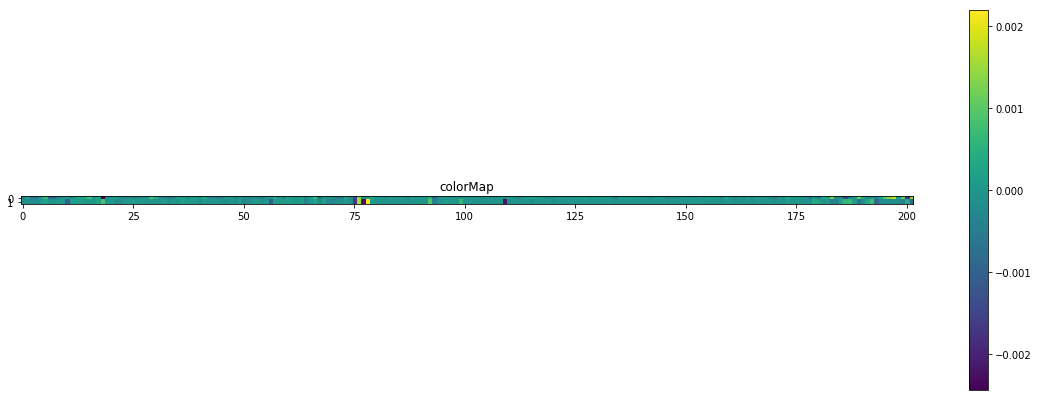

In [76]:
# PCA plots
# dfc_pca_results = vs.pca_results(dfc_clean, dfc_pca)

#ICA plots
# pca_fig = plt.figure(figsize=(20, 7))
# ax = pca_fig.add_subplot(111)
# ax.set_title('colorMap')
# plt.imshow(dfc_ica_components)
# ax.set_aspect('equal')
# cax = pca_fig.add_axes([-1000, 1000, -1000, 1000])
# cax.get_xaxis().set_visible(False)
# cax.get_yaxis().set_visible(False)
# cax.patch.set_alpha(0)
# cax.set_frame_on(False)
# plt.colorbar(orientation='vertical')
# plt.show()

# #RP plots
# dfc_RP_fig = plt.figure(figsize=(20, 7))
# ax = fig.add_subplot(111)
# ax.set_title('colorMap')
# plt.imshow(dfc_RP_components)
# ax.set_aspect('equal')
# #cax = fig.add_axes([-1000, 1000, -1000, 1000])
# cax.get_xaxis().set_visible(False)
# cax.get_yaxis().set_visible(False)
# cax.patch.set_alpha(0)
# cax.set_frame_on(False)
# plt.colorbar(orientation='vertical')
# plt.show()

# #FA plots
# dfc_FA_fig = plt.figure(figsize=(20, 7))
# ax = fig.add_subplot(111)
# ax.set_title('colorMap')
# plt.imshow(dfc_FA_components)
# ax.set_aspect('equal')
# #cax = fig.add_axes([-1000, 1000, -1000, 1000])
# cax.get_xaxis().set_visible(False)
# cax.get_yaxis().set_visible(False)
# cax.patch.set_alpha(0)
# cax.set_frame_on(False)
# plt.colorbar(orientation='vertical')
# plt.show()

In [80]:
def kmeans_reduced_clusters(data):
    kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
    kmeans_preds = kmeans.predict(data)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_score = metrics.silhouette_score(data, kmeans_preds)
    return kmeans_score

def EM_reduced_clusters(data):
    EM = GaussianMixture(n_components=3, random_state=0).fit(data)
    EM_preds = EM.predict(data)
    EM_centers = EM.means_
    EM_score = metrics.silhouette_score(data, EM_preds)
    return EM_score

print (kmeans_reduced_clusters(red_dfc_pca))
print (kmeans_reduced_clusters(red_dfc_ica)) 
print (kmeans_reduced_clusters(red_dfc_RP))
print (kmeans_reduced_clusters(red_dfc_FA))

print (EM_reduced_clusters(red_dfc_pca))
print (EM_reduced_clusters(red_dfc_ica)) 
print (EM_reduced_clusters(red_dfc_RP))
print (EM_reduced_clusters(red_dfc_FA))

0.42805346479609874
0.4366176033217567
0.31643777873431944
0.599471391770593
0.30628598875627705
0.2994836217537677
0.2759343670137826
0.6008717578745356


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

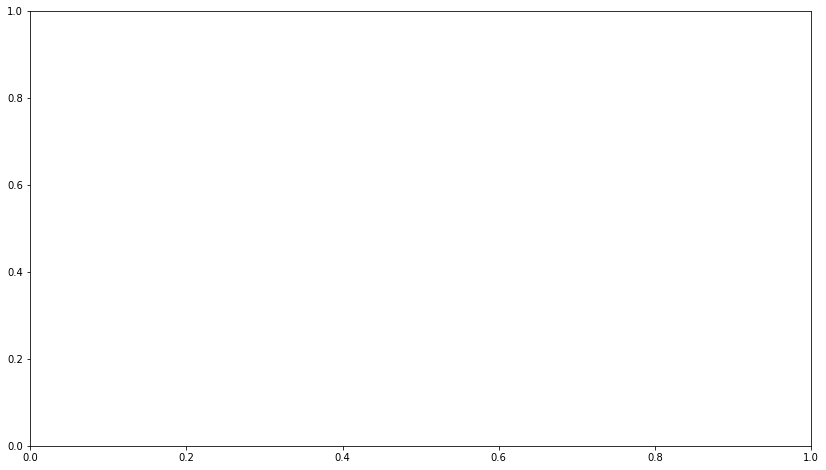

In [81]:
vs.biplot(dfc_clean, red_dfc_pca, dfc_pca)